In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
# using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [15]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies E_C/E_J
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))
Phi1 = -im/2 .* kron(spdiagm(+1 => ones(N - 1)) - spdiagm(-1 => ones(N - 1)), Id)
# Phi1 = -im/2 .* kron(spdiagm(+1 => ones(N - 1)) - spdiagm(0 => ones(N)), Id)


Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [16]:
A = 2pi*1e-6 #1/sqrt(Hz)
tanloss = 2e-7
T = 2*2.618 #GHz #note the factor two??
C = sqrt(abs(log(2*pi*1e-6)))
tmp_Es, tmp_ψs = eigs(2pi * E_J_GHz .* (prefactor .* n^2 + 1 / 2 .* (exp_iPhi .+ exp_iPhi')), nev=2, which=:SR, tol=0.0, maxiter=10000)

ω = real(tmp_Es[2] - tmp_Es[1])*2pi*E_J_GHz
S = ω^2*tanloss/(2pi*E_J_GHz*4*E_C)*(coth(ω/T)+1)

# M = alpha.*tmp_ψs'*dPot3_dphi(phi_ext)*tmp_ψs
phi = abs2((tmp_ψs'*(-im/2 .* (spdiagm(+1 => ones(N - 1)) - spdiagm(-1 => ones(N - 1))))*tmp_ψs)[1,2])

# tmpGammaPhi = sqrt(2)*A*C*abs(M[2,2]-M[1,1])
tmpGamma1 = S*phi

0.023268865470442036

In [40]:
1e-9/tmpGamma1

4.297588128094512e-8

In [26]:
(1e-9 / tmpGamma1)\(1e-9 / Gamma1)

10282.996918839339

In [25]:
tmp_Es, tmp_ψs = eigs(KinPot12 + 1 .* get_Pot3(phi_ext), nev=2, which=:SR, tol=0.0, maxiter=10000)

ω = real(tmp_Es[2] - tmp_Es[1])*2pi*E_J_GHz

S = ω^2*tanloss/(2pi*E_J_GHz*4*E_C)*(coth(ω/T)+1)

M = 1 .*tmp_ψs'*dPot3_dphi(phi_ext)*tmp_ψs
phi = abs2((tmp_ψs'*Phi1*tmp_ψs)[1,2])

GammaPhi = sqrt(2)*A*C*abs(M[2,2]-M[1,1])
Gamma1 = S*phi

2.2628486280892938e-6

In [27]:
function infidel_deco(t,Gamma1, GammaPhi)
    Gamma2 = Gamma1/2 + GammaPhi
    0.5 - exp(-Gamma1*t)/6 - 2*exp(-Gamma2*t)/6
end


A = 2pi*1e-6 #1/sqrt(Hz)
tanloss = 2e-7
T = 2*2.618 #GHz #note the factor two??
C = sqrt(abs(log(2*pi*1e-6)))
function Get_Gammas(alpha,phi_ext=phi_ext)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha .* get_Pot3(phi_ext), nev=2, which=:SR, tol=0.0, maxiter=10000)

    ω = real(tmp_Es[2] - tmp_Es[1])*2pi*E_J_GHz

    S = ω^2*tanloss/(2pi*E_J_GHz*4*E_C)*(coth(ω/T)+1)

    M = alpha.*tmp_ψs'*dPot3_dphi(phi_ext)*tmp_ψs
    phi = abs2((tmp_ψs'*Phi1*tmp_ψs)[1,2])

    GammaPhi = sqrt(2)*A*C*abs(M[2,2]-M[1,1])
    Gamma1 = S*phi
    return Gamma1, GammaPhi
end


Get_Gammas (generic function with 2 methods)

In [28]:
Gamma1 = []
GammaPhi = []
alpharange = LinRange(0.5,1,100)
Gs = alpha -> Get_Gammas(alpha, 0.995pi)

for alpha in alpharange
    (G1, GPhi) = Gs(alpha)
    push!(Gamma1,G1)
    push!(GammaPhi,GPhi)
end

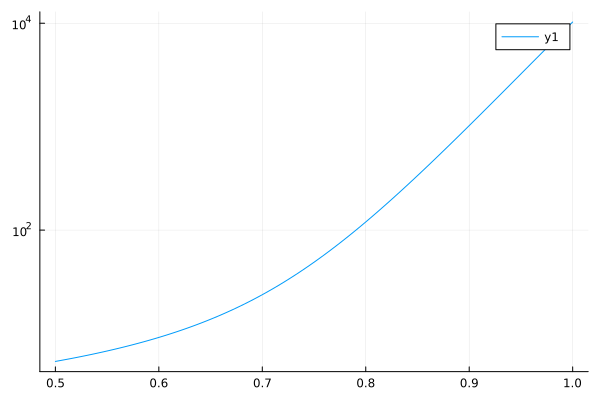

In [38]:
plot(alpharange,(tmpGamma1) ./ ( Gamma1),yscale=:log10)

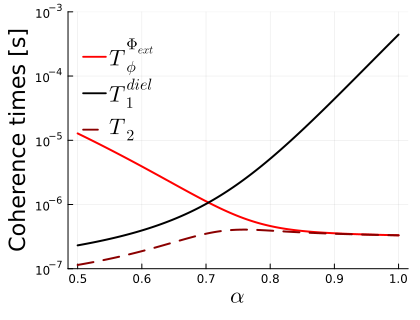

In [360]:
T1 = 1e-9 ./ Gamma1[50,:]
Tphi = 1e-9 ./GammaPhi[50,:]
T2 = 1 ./(1 ./(2 .*T1) + 1 ./Tphi)
T2 = 1e-9 ./ (2*Gamma1[50,:] + GammaPhi[50,:])
plt = plot(alpharange, [Tphi,T1, T2],
     yscale=:log10,
     lw=2,
     legend=:topleft,
     ylabel="Coherence times [s]",
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     ls=[:solid :solid :dash],
     label=[L"$T_\phi^{\Phi_{ext}}$" L"$T_1^{diel}$" L"$T_2$"],
     legendfontsize=15,
     xlabel=L"$\alpha$",
     labelfontsize=15,
     color=["red" "black" "darkred"],
     ylim=(1e-7,1e-3),size=(420,320))
# savefig(plt,"CoherenceTimes.pdf")

In [127]:
N_alpha, N_Phi = (100,100)

Gamma1 = zeros(N_Phi,N_alpha)
GammaPhi = zeros(N_Phi,N_alpha,)

alpharange = LinRange(0.5,1,N_alpha)
Phirange = LinRange(0.99pi,1.0pi,N_Phi)

for (i,Phi) in enumerate(Phirange)
    Gs = alpha -> Get_Gammas(alpha, Phi)
    for (j,alpha) in enumerate(alpharange)
        (G1, GPhi) = Gs(alpha)
        Gamma1[i,j] = G1
        GammaPhi[i,j] = GPhi
    end
end

In [128]:
Gamma2 = Gamma1 ./2 + GammaPhi ;

In [224]:
# plot(alpharange,[Gamma2[end-1,:],Gamma2[end,:]],yscale=:log10)
Gamma2

100×100 Matrix{Float64}:
 0.00232612  0.00229027  0.00225488  …  0.003005    0.00301196  0.00301876
 0.00232439  0.00228845  0.00225296     0.00300498  0.00301194  0.00301875
 0.00232266  0.00228663  0.00225105     0.00300496  0.00301193  0.00301874
 0.00232093  0.00228481  0.00224913     0.00300495  0.00301191  0.00301872
 0.00231921  0.00228299  0.00224722     0.00300493  0.0030119   0.00301871
 0.00231748  0.00228118  0.0022453   …  0.00300491  0.00301188  0.00301869
 0.00231575  0.00227936  0.00224339     0.00300488  0.00301186  0.00301868
 0.00231403  0.00227754  0.00224148     0.00300486  0.00301184  0.00301866
 0.00231231  0.00227573  0.00223956     0.00300484  0.00301182  0.00301865
 0.00231058  0.00227391  0.00223765     0.00300481  0.0030118   0.00301863
 ⋮                                   ⋱                          
 0.00217396  0.00212962  0.00208522     0.00284028  0.00286491  0.00288758
 0.00217237  0.00212793  0.00208343     0.00279465  0.00282368  0.0028504
 0.00217078

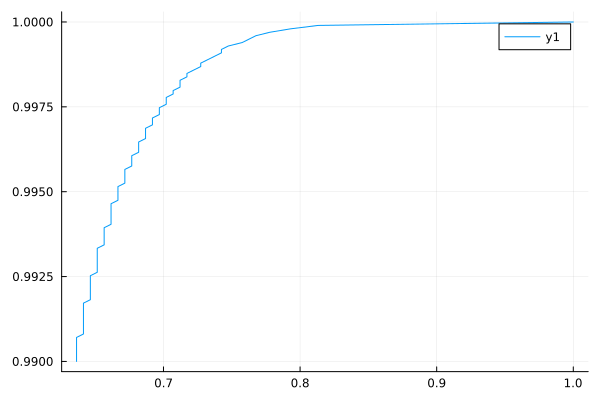

In [223]:
plot(alpharange[[tmp[2] for tmp in argmax(1e-3 ./Gamma2,dims=2)[:]]],Phirange/pi)

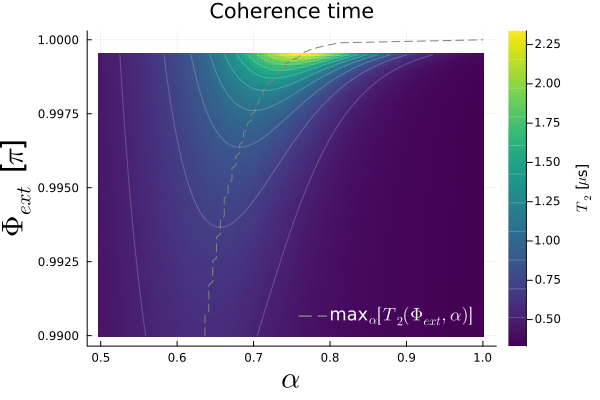

In [355]:
using LaTeXStrings
using Plots.PlotMeasures
# alpharange = LinRange(0.5,1,N_alpha)
# Phirange = LinRange(0.98pi,1.0pi,N_Phi)
# heatmap(alpharange,Phirange[1:end-1]/pi,1e-3 ./Gamma2[1:end-1,:],colorbarlabel="lol")

mask = 1:N_Phi-5
# vals = 3e-3 ./(Gamma1+GammaPhi)#*100*10
# vals = (Gamma1+GammaPhi) ./ 3 *100
vals = 1e-3 ./Gamma2#[mask,:]
# mask = 80:N_Phi-1
plt = heatmap(alpharange,Phirange[mask]/pi,
        vals[mask,:],
        # 1e-3 ./Gamma2[mask,:],
        colorbar_title="\n"*L"$T_2$ [$\mu$s]",
        # colorbar_title=L"$\frac{3}{\Gamma_1+\Gamma_\phi}$ [$\mu$s]",
        # colorbar_title="\n\"Infidelity rate\" (%/ns)",#L"$\frac{\Gamma_1+\Gamma_\phi}{3}\cdot 1ns$ (%)",
        # cticks=(0.1,"1"),
        c=:viridis,
        right_margin=20px)
plot!(alpharange[[tmp[2] for tmp in argmax(vals,dims=2)[:]]],Phirange/pi,
      c=:grey,ls=:dash,label=L"max$_\alpha[T_2(\Phi_{ext},\alpha)]$",legend=:bottomright,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontcolor=:white,
      legendfontsize=12)
contour!(alpharange,Phirange[mask]/pi,
         vals[mask,:],
        #  1e-3 ./Gamma2[mask,:],
         levels=10,c=:white,alpha=0.2,right_margin=20px,
        #  title="Decrease in fidelity due to decoherence",
         title="Coherence time",
         xlabel=L"$\alpha$",
         ylabel=L"$\Phi_{ext}$ [$\pi$]",
         labelfontsize=20)
# savefig(plt,"CoherenceTimeHeatmap.pdf")

In [153]:
Phirange[mask]/pi

100-element LinRange{Float64, Int64}:
 0.99,0.990101,0.990202,0.990303,0.990404,…,0.999697,0.999798,0.999899,1.0

In [106]:
Gamma1 = []
Gammaphi = []
alpharange = LinRange(0.5,1,100)
A=1e-6
C = abs(log(2*pi*1e-6))
for alpha in alpharange
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha .* Potential3, nev=4, which=:SR, tol=0.0, maxiter=10000)
    M = alpha.*tmp_ψs'*dPot3_dphi()*tmp_ψs
    dωq = min(abs(M[4,4] - M[1,1]),abs(M[3,3] - M[1,1]))
    push!(Gammaphi,A*C*dωq)
    push!(Gamma1,abs2(M[4,1])*(2pi)^2*A^2/real(tmp_Es[4]-tmp_Es[1]))
end

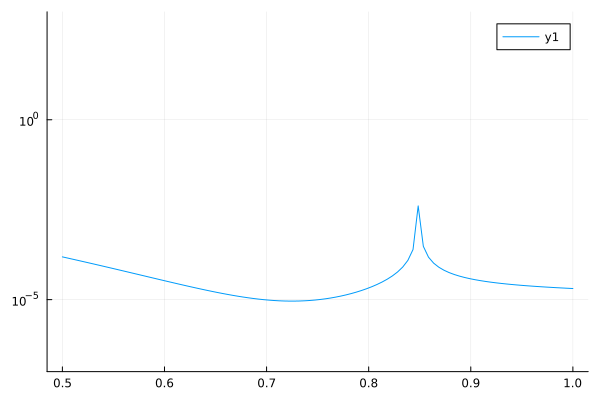

In [107]:
plot(alpharange, 1e-9 ./Gammaphi,yscale=:log10,ylim=(1e-7,1e3))
# plot(alpharange, 1e-9 ./Gamma1,yscale=:log10,ylim=(1e-2,1e7),yticks=10)

# res

In [191]:
Aphi = 1e-6
C = abs(log(2*pi*1e-6))

function decoherence(alpha,t,A,omega_d)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000)
    M = alpha.*tmp_ψs'*dPot3_dphi()*tmp_ψs
    dωq = abs(M[2,2] - M[1,1])
    Γphi = Aphi*C*dωq
    if omega_d == nothing
        Δ = 0
    else
        Δ = real(tmp_Es[2] - tmp_Es[1]) - omega_d
    end
    d = abs((tmp_ψs'*chargecoupling*tmp_ψs)[1,2])
    if A == nothing
        A = pi/(d*t)
    end
    factor = Γphi/(16*(A^2*d^2+Δ^2)^2)
    theta = A*d*t
    C1 = A^4*d^4*(3*t*cos(theta)+2*t)
    C2 = A^3*d^3*(sin(theta)^3+sin(theta))
    C3 = A^2*d^2*Δ^2*(8*t*cos(theta)+4*t)
    C4 = 4*Δ^4*t*cos(theta)
    C5 = -Δ^2*A*d*sin(2*theta)
    return factor*(C1 + C2 + C3 + C4 + C5)
end

decoherence (generic function with 1 method)

In [192]:
N = 20
decos = zeros(N,N)
alphas = LinRange(0.5,1,N)
ts = LinRange(1,20,N)
for (i,alpha) in enumerate(alphas)
    for (j,t) in enumerate(ts)
        decos[i,j] = decoherence(alpha,t,nothing,nothing)
    end
end

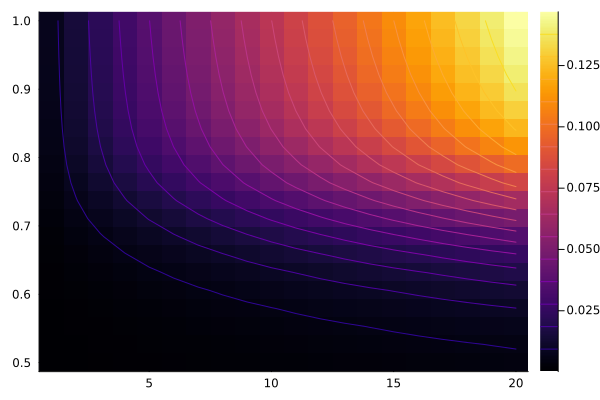

In [197]:
heatmap(ts,alphas,abs.(decos2)*100)
contour!(ts,alphas,abs.(decos)*100,color=:plasma)

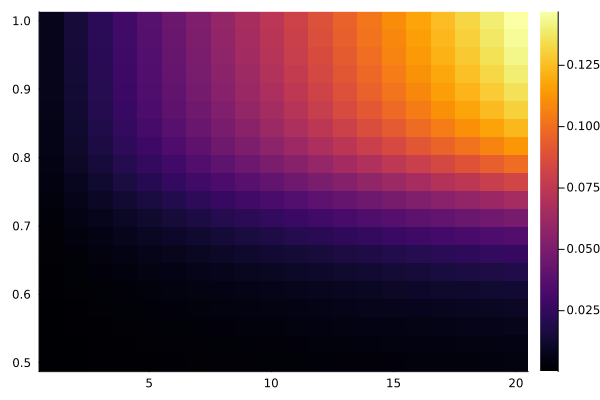

In [150]:
heatmap(ts,alphas,abs.(decos)*100)